In [1]:
using ReinforcementLearningAnIntroduction

┌ Info: Precompiling ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936].
└ @ Base loading.jl:1033
┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/tj/.julia/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


In [2]:
using StatsBase, Plots

In [3]:
const N = 21

const true_values = -1:0.1:1

-1.0:0.1:1.0

In [4]:
Base.@kwdef struct RecordRMS <: AbstractHook
    rms::Vector{Float64}=[]
end

(h::RecordRMS)(::PostEpisodeStage, agent, env, obs) = push!(h.rms, sqrt(mean((agent.policy.learner.approximator.table[2:end-1] - true_values[2:end-1]).^2)))


In [5]:
function create_agent_env(α, λ)
    env = RandomWalkEnv(N=21)
    ns, na =  length(get_observation_space(env)),  length(get_action_space(env))
    agent = Agent(
        policy=VBasedPolicy(
            learner=TDλReturnLearner(
                approximator=TabularApproximator(n_state=ns),
                γ=1.0,
                α=α,
                λ=λ
            ),
            mapping = (obs, V) -> begin
                values = zeros(na)
                values[rand(1:na)] = 1.0
                values
            end
        ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    agent, env
end

function records(α, λ, nruns=10)
    rms = []
    for _ in 1:nruns
        hook = RecordRMS()
        run(create_agent_env(α, λ)..., StopAfterEpisode(10, is_show_progress=false),hook)
        push!(rms, mean(hook.rms))
    end
    mean(rms)
end

records (generic function with 2 methods)

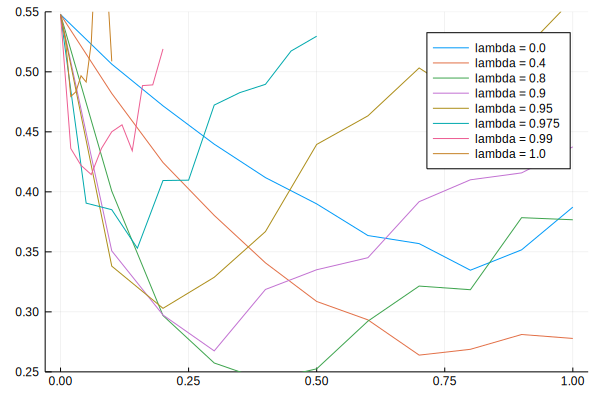

In [6]:
As = [0:0.1:1, 0:0.1:1, 0:0.1:1, 0:0.1:1, 0:0.1:1, 0:0.05:0.5, 0:0.02:0.2, 0:0.01:0.1]
Λ = [0., 0.4, .8, 0.9, 0.95, 0.975, 0.99, 1.]
p = plot(legend=:topright)
for (A, λ) in zip(As, Λ)
    plot!(p, A, [records(α, λ) for α in A], label="lambda = $λ")
end
ylims!(p, (0.25, 0.55))
p